In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
import delfi.distribution as dd
import numpy as np
import pickle
import time
import scipy.stats as st
import os 
from lfimodels.balancednetwork.BalancedNetworkSimulator import BalancedNetwork
from lfimodels.balancednetwork.BalancedNetworkStats import BalancedNetworkStats

In [98]:
path_to_save_folder = 'figures/'
save_figure = True

inference_method = 'basic'
filename = '15034905891797683_basic_ntrain750'
time_str = filename[:filename.find('_')]
filename.find('_')
fullname = 'data/' + filename + '.p'

In [99]:
# load data 
with open(fullname, 'rb') as handle:
    result_dict = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'data/15034905891797683_basic_ntrain750.p'

In [81]:
# unpack values 
true_params, stats_obs, nrounds, ntrain, posterior, out, trn_data = result_dict.values()
assert len(true_params) == 1, 'this notebook is for inference on 1 parameter.'

In [75]:
nrounds = len(out)

In [76]:
# extract the posterior 
n_components = len(posterior.a)
means = [posterior.xs[c].m for c in range(n_components)]
Ss = [posterior.xs[c].S for c in range(n_components)]

## Compare to true parameter 

We have generated the observed data ourselves so we do have the true parameter. The mean of the posterior should be close to it when evaluated for $x=x_{obs}$

In [77]:
theta = np.linspace(0, 5, 1000)
sub_means = [[means[c][0]] for c in range(n_components)]
sub_cov = np.asarray([Ss[c] for c in range(n_components)])
pdf = dd.mixture.MoG(a=posterior.a, ms=sub_means, Ss=sub_cov)
post_pdf = pdf.eval(theta[:, np.newaxis], log=False)

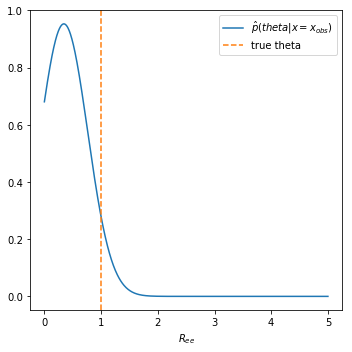

In [78]:
plt.figure(figsize=(5, 5))
plt.plot(theta, post_pdf, label='$\hat{p}( theta | x=x_{obs})$')
plt.axvline(x=true_params[0], label='true theta', linestyle='--', color='C1')
plt.legend()
plt.xlabel('$R_{ee}$');
filename = time_str + '_{}_posterior_r{}_ntrain{}.pdf'.format(inference_method, nrounds, ntrain)
plt.tight_layout()

if save_figure and os.path.exists(path_to_save_folder): 
    plt.savefig(os.path.join(path_to_save_folder,filename))

## Posterior predictive checking 

Generate samples from the posterior and simulate them. The resulting data should be near the observed data. 

In [53]:
m = BalancedNetwork(n_servers=2, duration=3., first_port=8010, 
                    save_raster_plots=True, 
                    save_folder='/Users/Jan/Dropbox/Master/mackelab/code/lfi-experiments/balancednetwork/figures/simulation_raster_plots/')
s = BalancedNetworkStats(n_workers=2)

In [54]:
# calculate mean of mixture 
mean = np.sum([a * m[0] for a, m in zip(posterior.a, means)])
# calculate variance of mixture 
sum_squared = np.sum([a * m[0]**2 for a, m in zip(posterior.a, means)])
squared_sum = mean**2
std = np.sum([a * Ss[0][0] for a, m in zip(posterior.a, Ss)]) + sum_squared - squared_sum

In [55]:
m.start_server()
# generate theta +-3, 2, 1 0 stds away from mode
thetas = [mean + i * std for i in [-2, -1, 0, 1, 2]]
sum_stats = []
# simulate and collect sum stats
data = m.gen(thetas)

starting 1 / 5. total time remaining: ca. 1.5min 
starting 2 / 5. total time remaining: ca. 1.0min 
starting 3 / 5. total time remaining: ca. 1.0min 
starting 4 / 5. total time remaining: ca. 0.5min 
starting 5 / 5. total time remaining: ca. 0.5min 
Done


In [56]:
sum_stats = s.calc_all(data)

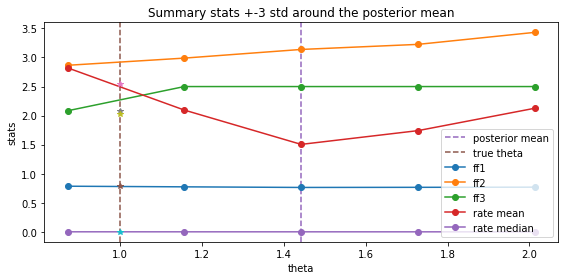

In [57]:
# plot the resulting stats with the observed stats 
plt.figure(figsize=(8, 4))
sum_stats = np.array(sum_stats).squeeze()
plt.axvline(x=mean, linestyle='--', color='C4')
plt.axvline(x=true_params, linestyle='--', color='C5')
plt.plot(thetas, sum_stats, '-o')
plt.plot(true_params, stats_obs, '*')
plt.legend(['posterior mean', 'true theta', 'ff1', 'ff2', 'ff3', 'rate mean', 'rate median'])
plt.xlabel('theta')
plt.ylabel('stats')
plt.title('Summary stats +-3 std around the posterior mean')
filename = '{}_ppch_r{}_ntrain{}.pdf'.format(inference_method, nrounds, ntrain)
plt.tight_layout()
if save_figure and os.path.exists(path_to_save_folder): 
    plt.savefig('figures/' + filename)